In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector , Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import utils,optimizers
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from seaborn.rcmod import palettes
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/研究所課程/期末專題_捷運/新站點/data/最終資料/修改日期後資料/借車/象山.csv')
df = df.iloc[:,1:]
df

,時間,借車數,氣溫,相對溼度,風速,降水量,紫外線指數,捷運站,出站人數,進站人數,hour,星期
0,2021-07-03 00:00:00,6.0,28.2,70.0,0.8,0.0,0.0,象山,49.0,77.0,0,Saturday
1,2021-07-10 00:00:00,5.0,27.0,75.0,1.2,0.0,0.0,象山,42.0,66.0,0,Saturday
2,2021-07-17 00:00:00,8.0,30.8,61.0,0.8,0.0,0.0,象山,44.0,70.0,0,Saturday
3,2021-07-24 00:00:00,1.0,28.8,66.0,1.0,0.0,0.0,象山,51.0,66.0,0,Saturday
4,2021-07-03 06:00:00,4.0,27.2,72.0,1.1,0.0,0.0,象山,127.0,113.0,6,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
739,2021-07-02 23:00:00,15.0,28.5,67.0,1.0,0.0,0.0,象山,156.0,175.0,23,Friday
740,2021-07-09 23:00:00,5.0,27.2,76.0,1.5,0.0,0.0,象山,158.0,238.0,23,Friday
741,2021-07-16 23:00:00,11.0,31.0,61.0,2.0,0.0,0.0,象山,154.0,226.0,23,Friday
742,2021-07-23 23:00:00,9.0,28.7,67.0,1.1,0.0,0.0,象山,134.0,204.0,23,Friday


In [ ]:
df['時間'] = pd.to_datetime(df['時間'])
df = df.sort_values(by=['時間'])

In [ ]:
df = df.drop('捷運站',axis=1)

In [ ]:
Old = df.copy()

In [ ]:
df.set_index("時間" , inplace=True)

In [ ]:
cc = round(df['借車數'].rolling(3, min_periods=1).mean(),0)
cc = pd.DataFrame(cc,columns=['借車數'],index=df.index)
cc

,借車數
時間,
2021-07-01 00:00:00,9.0
2021-07-01 01:00:00,6.0
2021-07-01 02:00:00,5.0
2021-07-01 03:00:00,3.0
2021-07-01 04:00:00,3.0
...,...
2021-07-31 19:00:00,28.0
2021-07-31 20:00:00,28.0
2021-07-31 21:00:00,19.0


In [ ]:
cc = cc.rename(columns={'借車數':'new_Lend'})

In [ ]:
df = pd.concat([df,cc],axis=1)
df

,借車數,氣溫,相對溼度,風速,降水量,紫外線指數,出站人數,進站人數,hour,星期,new_Lend
時間,,,,,,,,,,,
2021-07-01 00:00:00,9.0,27.3,75.0,0.9,0.0,0.0,84.0,115.0,0,Thursday,9.0
2021-07-01 01:00:00,2.0,27.4,74.0,1.2,0.0,0.0,0.0,0.0,1,Thursday,6.0
2021-07-01 02:00:00,3.0,27.2,74.0,1.6,0.0,0.0,0.0,0.0,2,Thursday,5.0
2021-07-01 03:00:00,3.0,27.0,75.0,0.1,0.0,0.0,0.0,0.0,3,Thursday,3.0
2021-07-01 04:00:00,3.0,27.1,73.0,1.3,0.0,0.0,0.0,0.0,4,Thursday,3.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,27.0,30.0,62.0,1.3,0.0,0.0,575.0,1646.0,19,Saturday,28.0
2021-07-31 20:00:00,21.0,29.4,69.0,0.3,0.0,0.0,392.0,820.0,20,Saturday,28.0
2021-07-31 21:00:00,10.0,29.1,72.0,1.5,0.0,0.0,433.0,502.0,21,Saturday,19.0


In [ ]:
KK = df.copy()
KK = KK.rename(columns={'借車數':'Rent','氣溫':'Temperature','相對溼度':'Humidity','風速':'Speed','降水量':'Rain','紫外線指數':'UV','出站人數':'Leave','進站人數':'Arrive','星期':'Weeks'})

In [ ]:
Old = Old.rename(columns={'借車數':'Rent','氣溫':'Temperature','相對溼度':'Humidity','風速':'Speed','降水量':'Rain','紫外線指數':'UV','出站人數':'Leave','進站人數':'Arrive','星期':'Weeks'})

In [ ]:
df = df.drop('hour',axis=1)
df = df.drop('星期',axis=1)

In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day

In [ ]:
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Text(0.5, 1.0, 'Rents in City Hall')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)


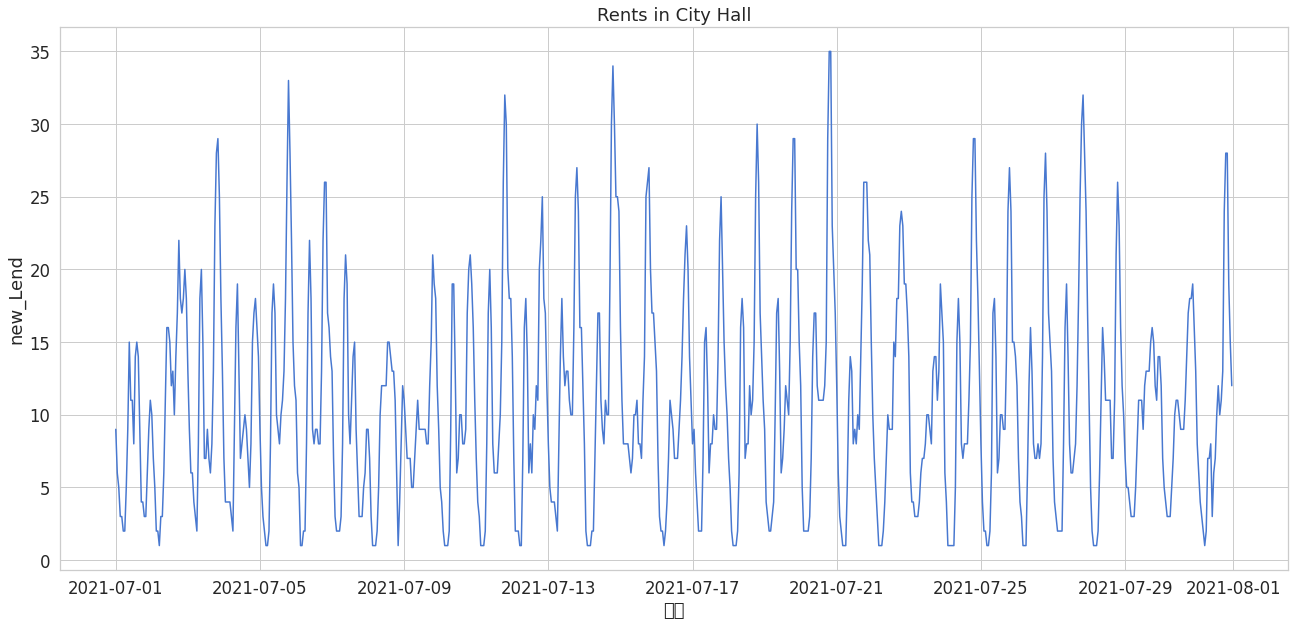

In [ ]:
sns.lineplot(x=KK.index,y='new_Lend',data=KK)
plt.title('Rents in City Hall')

Text(0.5, 1.0, 'Number of leaving in National Dr Sun Yat-sen Memorial Hall')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)


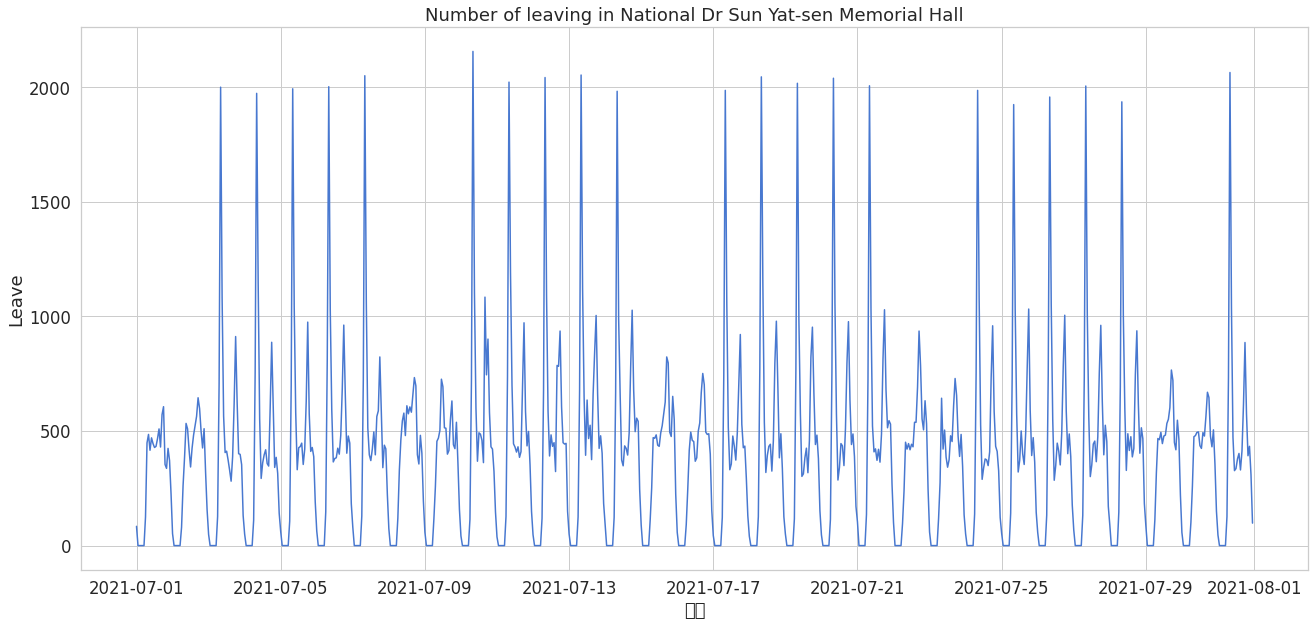

In [ ]:
sns.lineplot(x=KK.index,y='Leave',data=KK)
plt.title('Number of leaving in National Dr Sun Yat-sen Memorial Hall')

Text(0.5, 1.0, 'Number of entering in National Dr Sun Yat-sen Memorial Hall')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)


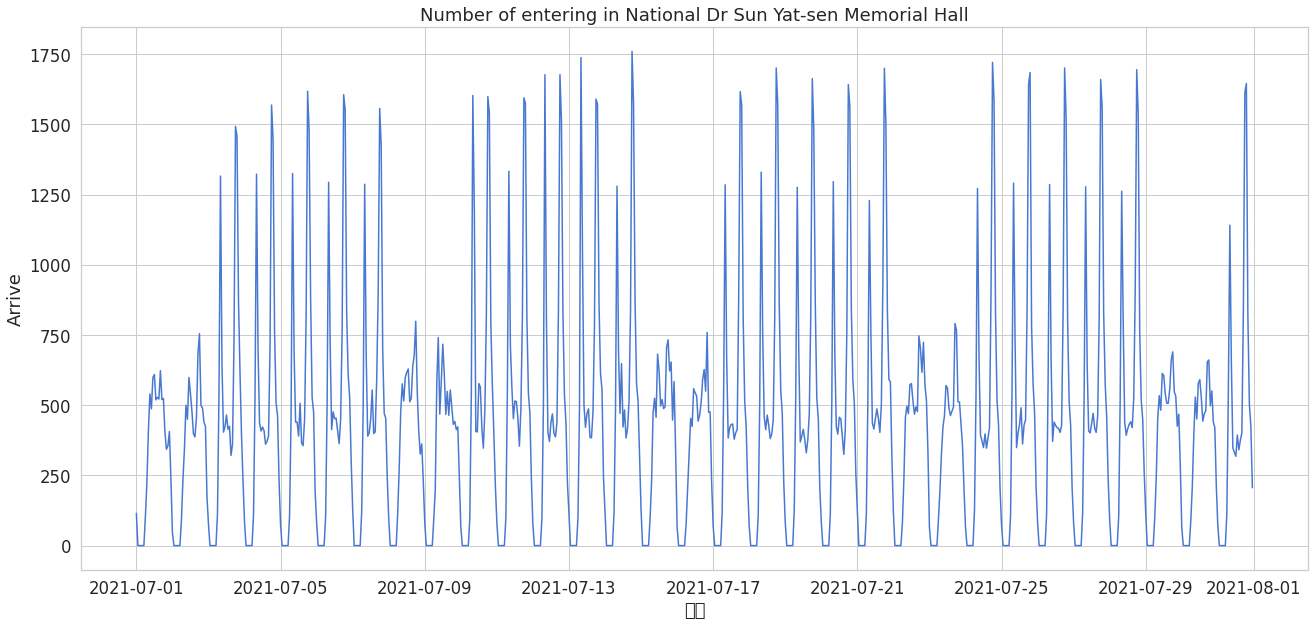

In [ ]:
sns.lineplot(x=KK.index,y='Arrive',data=KK)
plt.title('Number of entering in National Dr Sun Yat-sen Memorial Hall')

Text(0.5, 1.0, 'Rents in Hours National Dr Sun Yat-sen Memorial Hall')

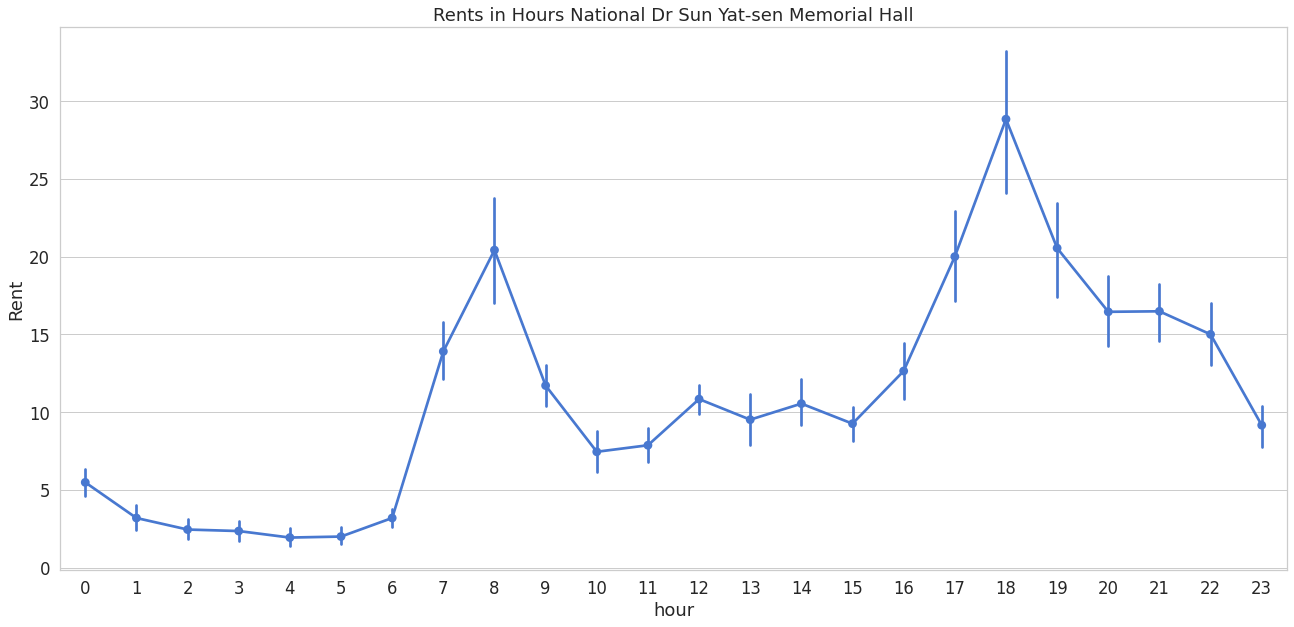

In [ ]:
sns.pointplot(x='hour',y='Rent',data=KK)
plt.title('Rents in Hours National Dr Sun Yat-sen Memorial Hall')

In [ ]:
def insert_time(row):
  return row['時間'].replace(year=2017)
Old['時間'] = Old.apply(lambda r: insert_time(r), axis=1)
Old = Old.drop('Weeks',axis=1)

In [ ]:
import calendar
def week_add(a):
  c = []
  for i in range(len(a)):
    aa = a['時間'][i]
    b = calendar.day_name[aa.weekday()]
    c.append(b)
  a['Weeks'] = pd.DataFrame(c)
  return a

Text(0.5, 1.0, 'Rents in Weeks Taipei101')

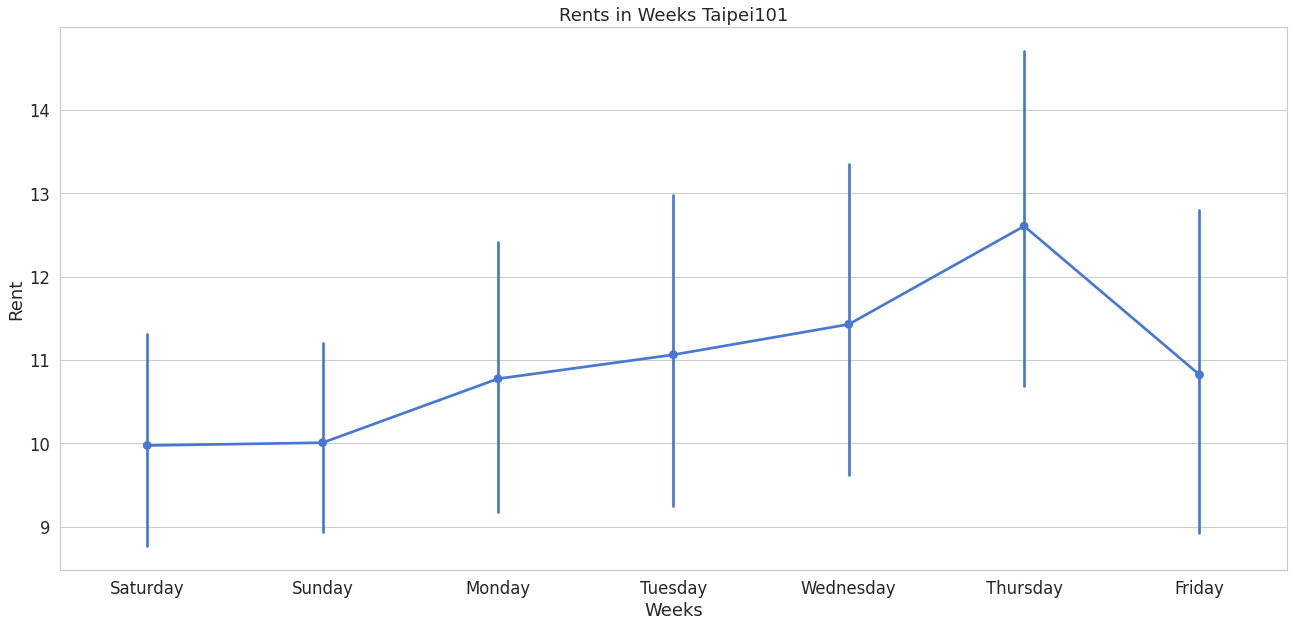

In [ ]:
Old1 = week_add(Old)
sns.pointplot(x='Weeks',y='Rent',data=Old1)
plt.title('Rents in Weeks Taipei101')

In [ ]:
df = df.drop('hour',axis=1)
df = df.drop('day_of_week',axis=1)
df = df.drop('day_of_month',axis=1)
df = df.drop('借車數',axis=1)

In [ ]:
train_size = int(len(df)*0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(669, 8) (75, 8)


In [ ]:
test_index = test.index
test_index

DatetimeIndex(['2021-07-28 21:00:00', '2021-07-28 22:00:00',
               '2021-07-28 23:00:00', '2021-07-29 00:00:00',
               '2021-07-29 01:00:00', '2021-07-29 02:00:00',
               '2021-07-29 03:00:00', '2021-07-29 04:00:00',
               '2021-07-29 05:00:00', '2021-07-29 06:00:00',
               '2021-07-29 07:00:00', '2021-07-29 08:00:00',
               '2021-07-29 09:00:00', '2021-07-29 10:00:00',
               '2021-07-29 11:00:00', '2021-07-29 12:00:00',
               '2021-07-29 13:00:00', '2021-07-29 14:00:00',
               '2021-07-29 15:00:00', '2021-07-29 16:00:00',
               '2021-07-29 17:00:00', '2021-07-29 18:00:00',
               '2021-07-29 19:00:00', '2021-07-29 20:00:00',
               '2021-07-29 21:00:00', '2021-07-29 22:00:00',
               '2021-07-29 23:00:00', '2021-07-30 00:00:00',
               '2021-07-30 01:00:00', '2021-07-30 02:00:00',
               '2021-07-30 03:00:00', '2021-07-30 04:00:00',
               '2021-07-

In [ ]:
df

,氣溫,相對溼度,風速,降水量,紫外線指數,出站人數,進站人數,new_Lend
時間,,,,,,,,
2021-07-01 00:00:00,27.3,75.0,0.9,0.0,0.0,84.0,115.0,9.0
2021-07-01 01:00:00,27.4,74.0,1.2,0.0,0.0,0.0,0.0,6.0
2021-07-01 02:00:00,27.2,74.0,1.6,0.0,0.0,0.0,0.0,5.0
2021-07-01 03:00:00,27.0,75.0,0.1,0.0,0.0,0.0,0.0,3.0
2021-07-01 04:00:00,27.1,73.0,1.3,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,30.0,62.0,1.3,0.0,0.0,575.0,1646.0,28.0
2021-07-31 20:00:00,29.4,69.0,0.3,0.0,0.0,392.0,820.0,28.0
2021-07-31 21:00:00,29.1,72.0,1.5,0.0,0.0,433.0,502.0,19.0


In [ ]:
f_columns = ['氣溫', '相對溼度', '風速','降水量','紫外線指數','出站人數', '進站人數']
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['new_Lend']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['new_Lend'] = cnt_transformer.transform(train[['new_Lend']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['new_Lend'] = cnt_transformer.transform(test[['new_Lend']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-601-0618988d4d8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X)- time_steps):
    v = X.iloc[i:(i+time_steps),0:7].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
Time_step = 1
X_train, y_train = create_dataset(train, train.new_Lend, time_steps=Time_step)
X_test, y_test = create_dataset(test, test.new_Lend, time_steps=Time_step)

In [ ]:
print(X_train.shape, y_train.shape)

(668, 1, 7) (668,)


In [ ]:
print(X_test.shape, y_test.shape)

(74, 1, 7) (74,)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=256,activation='relu',return_sequences=True),
                                     input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64,activation='relu',return_sequences=True)))
model.add(Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=16,activation='relu')))
model.add(Flatten())
model.add(Dense(10,activation='linear'))
model.add(keras.layers.Dense(units=1))

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='MSE',optimizer=opt)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_33 (Bidirecti  (None, 1, 512)           540672    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_34 (Bidirecti  (None, 1, 128)           295424    
 onal)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_35 (Bidirecti  (None, 32)               18560     
 onal)                                                           
                                                     

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/200
19/19 [==============================] - 9s 74ms/step - loss: 0.6927 - val_loss: 0.8796
Epoch 2/200
19/19 [==============================] - 0s 23ms/step - loss: 0.6857 - val_loss: 0.8699
Epoch 3/200
19/19 [==============================] - 0s 22ms/step - loss: 0.6772 - val_loss: 0.8578
Epoch 4/200
19/19 [==============================] - 0s 21ms/step - loss: 0.6667 - val_loss: 0.8427
Epoch 5/200
19/19 [==============================] - 0s 22ms/step - loss: 0.6534 - val_loss: 0.8229
Epoch 6/200
19/19 [==============================] - 0s 23ms/step - loss: 0.6366 - val_loss: 0.7966
Epoch 7/200
19/19 [==============================] - 0s 22ms/step - loss: 0.6144 - val_loss: 0.7620
Epoch 8/200
19/19 [==============================] - 0s 23ms/step - loss: 0.5847 - val_loss: 0.7168
Epoch 9/200
19/19 [==============================] - 0s 23ms/step - loss: 0.5487 - val_loss: 0.6586
Epoch 10/200
19/19 [==============================] - 0s 22ms/step - loss: 0.5032 - val_loss: 0.5890

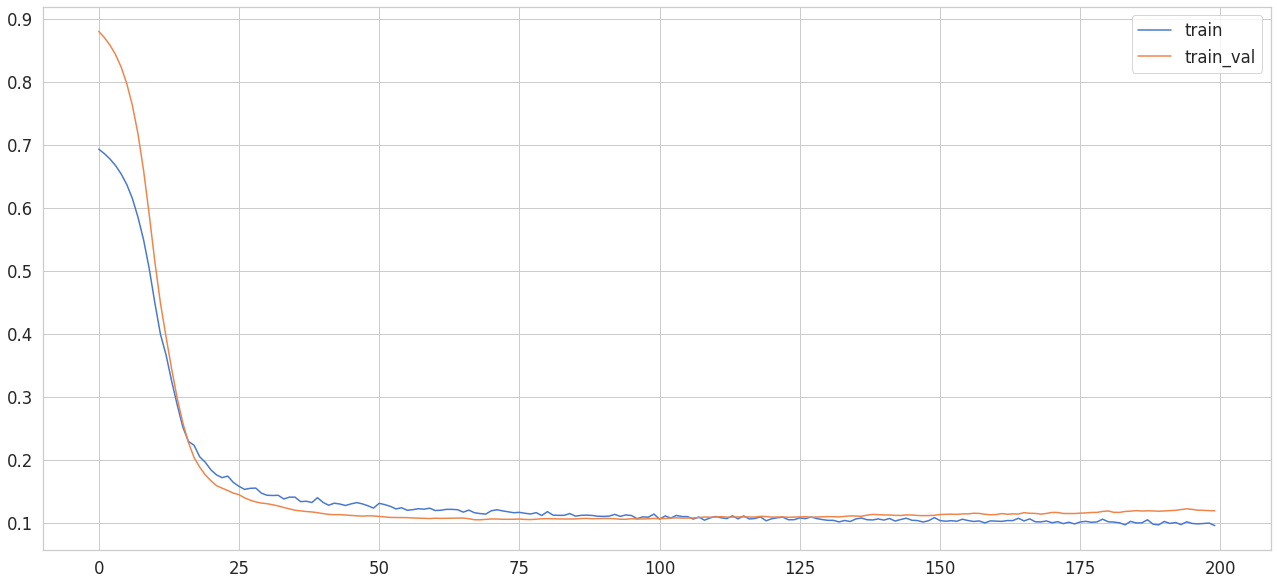

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='train_val')
plt.legend()

In [ ]:
y_pre = model.predict(X_test)

3/3 [==============================] - 1s 7ms/step


In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pre_inv = cnt_transformer.inverse_transform(y_pre)

In [ ]:
test_index = pd.DataFrame(test_index)
test_index = test_index.drop(index=0)
test_index = test_index['時間'].tolist()

In [ ]:
p1 = pd.DataFrame(y_test_inv.flatten())
p2 = pd.DataFrame(y_pre_inv.flatten())
mix_data = pd.concat([p1,p2],axis=1)
mix_data.columns = ['y_test_inv','y_pre_inv']
mix_data.index = test_index
mix_data

,y_test_inv,y_pre_inv
2021-07-28 22:00:00,12.0,6.508174
2021-07-28 23:00:00,10.0,8.605217
2021-07-29 00:00:00,7.0,3.716547
2021-07-29 01:00:00,5.0,5.404750
2021-07-29 02:00:00,5.0,2.743111
...,...,...
2021-07-31 19:00:00,28.0,26.328476
2021-07-31 20:00:00,28.0,26.349352
2021-07-31 21:00:00,19.0,19.387358
2021-07-31 22:00:00,15.0,15.168343


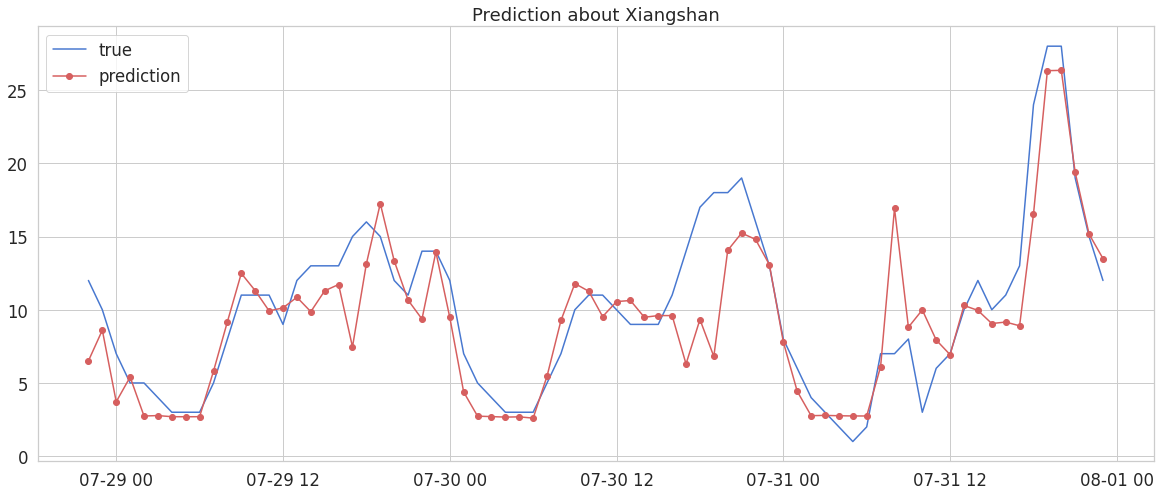

In [ ]:
fig, axs = plt.subplots(figsize=(20,8), sharey = True)
plt.plot(mix_data['y_test_inv'], label='true')
plt.plot(mix_data['y_pre_inv'], 'r', marker='o', label='prediction')
plt.title('Prediction about Xiangshan')
plt.legend()

In [ ]:
print(f'MAE {mean_absolute_error(y_test, y_pre)}')
print(f'MSE {mean_squared_error(y_test, y_pre)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pre))}')
print(f'R2 {r2_score(y_test, y_pre)}')

MAE 0.2291037208923662
MSE 0.12126488936471325
RMSE 0.3482310861550319
R2 0.695957982538736


In [ ]:
#model.save('/content/drive/MyDrive/研究所課程/期末專題_捷運/新站點/LSTM模型/借車/lstm_台北_model.h5')

In [ ]:
import pandas as pd

df2 = pd.read_csv('/content/drive/MyDrive/研究所課程/期末專題_捷運/新站點/8月站點/象山.csv')
df2 = df2.iloc[0:72,1:]
df2

,時間,測站氣壓,氣溫,相對溼度,風速,降水量,紫外線指數,捷運站,出站人數,進站人數
0,2021-08-01 00:00:00,998.9,27.4,76,1.9,0.0,0,象山,48.0,50.0
1,2021-08-01 01:00:00,998.4,27.3,74,1.2,0.0,0,象山,4.0,0.0
2,2021-08-01 02:00:00,998.2,27.1,75,0.8,0.0,0,象山,0.0,0.0
3,2021-08-01 03:00:00,998.3,26.9,76,0.9,0.0,0,象山,0.0,0.0
4,2021-08-01 04:00:00,998.2,26.8,76,1.0,0.0,0,象山,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
67,2021-08-03 19:00:00,998.9,27.1,85,0.9,4.0,0,象山,555.0,1511.0
68,2021-08-03 20:00:00,999.4,27.5,85,0.7,0.0,0,象山,419.0,703.0
69,2021-08-03 21:00:00,1000.1,27.7,85,0.9,0.0,0,象山,485.0,505.0
70,2021-08-03 22:00:00,1000.7,27.6,86,1.0,0.0,0,象山,403.0,439.0


In [ ]:
df2.set_index("時間" , inplace=True)

In [ ]:
df2

,氣溫,相對溼度,風速,降水量,紫外線指數,出站人數,進站人數
時間,,,,,,,
2021-08-01 00:00:00,27.4,76,1.9,0.0,0,48.0,50.0
2021-08-01 01:00:00,27.3,74,1.2,0.0,0,4.0,0.0
2021-08-01 02:00:00,27.1,75,0.8,0.0,0,0.0,0.0
2021-08-01 03:00:00,26.9,76,0.9,0.0,0,0.0,0.0
2021-08-01 04:00:00,26.8,76,1.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2021-08-03 19:00:00,27.1,85,0.9,4.0,0,555.0,1511.0
2021-08-03 20:00:00,27.5,85,0.7,0.0,0,419.0,703.0
2021-08-03 21:00:00,27.7,85,0.9,0.0,0,485.0,505.0


In [ ]:
df2 = df2.drop('捷運站',axis=1)
df2 = df2.drop('測站氣壓',axis=1)
df2['new_Lend'] = np.nan
df2.loc[:, f_columns] = f_transformer.transform(df2[f_columns].to_numpy())
df2['new_Lend'] = cnt_transformer.transform(df2[['new_Lend']])
X_test2, y_test2 = create_dataset(df2, df2.new_Lend, time_steps=Time_step)
X_test2.shape

NameError: ignored

In [ ]:
y_pt = model.predict(X_test2)

4/4 [==============================] - 0s 6ms/step


In [ ]:
y_pt_inv = cnt_transformer.inverse_transform(y_pt)

In [ ]:
y_pt_inv = pd.DataFrame(y_pt_inv,columns=['Lend'])
y_pt_inv

,Lend
0,4.179299
1,2.991083
2,2.954731
3,2.994742
4,2.985242
...,...
114,22.130978
115,19.722687
116,18.056721
117,17.316841


In [ ]:
time = df2.index
time = pd.DataFrame(time)
time = time.drop(index=119)
time

,時間
0,2021-08-01 00:00:00
1,2021-08-01 01:00:00
2,2021-08-01 02:00:00
3,2021-08-01 03:00:00
4,2021-08-01 04:00:00
...,...
114,2021-08-05 18:00:00
115,2021-08-05 19:00:00
116,2021-08-05 20:00:00
117,2021-08-05 21:00:00


In [ ]:
y_pt_inv = pd.concat([time,y_pt_inv],axis=1)
y_pt_inv

,時間,Lend
0,2021-08-01 00:00:00,4.179299
1,2021-08-01 01:00:00,2.991083
2,2021-08-01 02:00:00,2.954731
3,2021-08-01 03:00:00,2.994742
4,2021-08-01 04:00:00,2.985242
...,...,...
114,2021-08-05 18:00:00,22.130978
115,2021-08-05 19:00:00,19.722687
116,2021-08-05 20:00:00,18.056721
117,2021-08-05 21:00:00,17.316841


In [ ]:
y_pt_inv.to_csv('/content/drive/MyDrive/研究所課程/期末專題_捷運/新站點/8月站點/預測結果/借車/象山.csv')